## Importar base de datos

In [5]:
# Importar las librerías necesarias
import pandas as pd
from pgmpy.estimators import PC
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import BicScore
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import seaborn as sns
import seaborn as sns

In [6]:
df = pd.read_csv('datos_filtrados.csv')
df.head()

,cole_depto_ubicacion,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,punt_global
0,VALLE,Estrato 3,9 o más,Si,Si,No,No,274
1,VALLE,Estrato 5,3 a 4,Si,Si,Si,Si,270
2,VALLE,Estrato 1,3 a 4,No,No,No,Si,222
3,VALLE,Estrato 6,5 a 6,Si,Si,Si,Si,305
4,CUNDINAMARCA,Estrato 4,3 a 4,Si,Si,Si,Si,359


In [3]:
# Verificamos que no tenga punt_global vacíos
cont = 0
for i in range(0, (len(df['punt_global'])-1)):
    if df["punt_global"][i]=='NaN':
        cont += 1
if cont == 0:
    print('Súper! No hay valores vacíos.')
else:
    print('Ojo: Hay valores vacíos.')

Súper! No hay valores vacíos.


In [4]:
df['cole_depto_ubicacion'].unique()

array(['VALLE', 'CUNDINAMARCA', 'ANTIOQUIA', 'BOGOTÁ', 'CAUCA',
       'RISARALDA', 'SANTANDER', 'QUINDIO', 'NARIÑO', 'ATLANTICO',
       'SUCRE', 'CALDAS', 'META', 'MAGDALENA', 'CASANARE', 'BOLIVAR',
       'NORTE SANTANDER', 'LA GUAJIRA', 'CESAR', 'TOLIMA', 'BOYACA',
       'GUAINIA', 'CORDOBA', 'HUILA', 'ARAUCA', 'PUTUMAYO', 'CHOCO',
       'CAQUETA'], dtype=object)

# Creación de Estructuras de Red

## Método de Restricciones

In [7]:
# Estimamos un modelo nuevo por el método de restricciones
tiempo_inicial = datetime.now()
est = PC(data=df)
modelo1 = est.estimate(variant="stable", max_cond_vars=8)
print(modelo1)
print(modelo1.nodes())
print(modelo1.edges())
tiempo_total = datetime.now() - tiempo_inicial
print('El tiempo computacional fue de: ' + str(tiempo_total))

  0%|          | 0/8 [00:00<?, ?it/s]

DAG with 7 nodes and 10 edges
['fami_personashogar', 'punt_global', 'fami_tienecomputador', 'cole_depto_ubicacion', 'fami_estratovivienda', 'fami_tieneautomovil', 'fami_tieneinternet']
[('punt_global', 'fami_personashogar'), ('punt_global', 'cole_depto_ubicacion'), ('punt_global', 'fami_estratovivienda'), ('punt_global', 'fami_tienecomputador'), ('punt_global', 'fami_tieneinternet'), ('cole_depto_ubicacion', 'fami_personashogar'), ('fami_estratovivienda', 'fami_personashogar'), ('fami_estratovivienda', 'cole_depto_ubicacion'), ('fami_tieneautomovil', 'fami_estratovivienda'), ('fami_tieneautomovil', 'punt_global')]
El tiempo computacional fue de: 0:31:17.992110


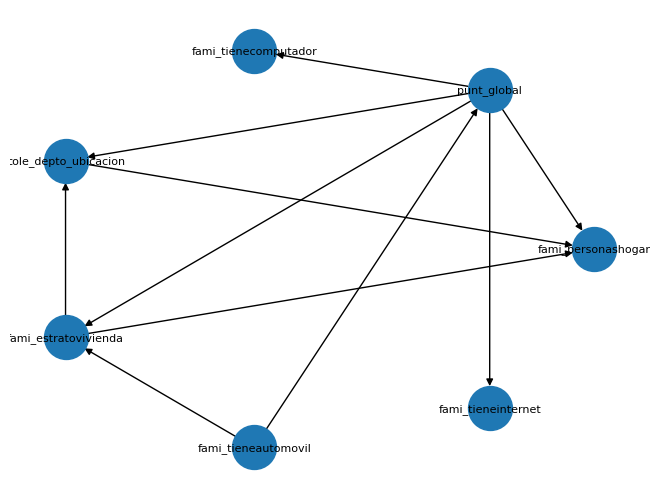

In [10]:
# Dibujamos el grafo
nx.draw_circular(modelo1,with_labels=True,arrowsize=10,font_size=8,node_size=1000)
plt.show()

In [11]:
# Evaluamos el modelo
print("Modelo por Restricciones:" + str(scoring_method.score(modelo1)))

Modelo por Restricciones:-234561.11951369114


In [24]:
# Editamos la base de datos para quedarnos con las columnas que nos interesan 
data_sel = ['fami_personashogar', 'punt_global', 'fami_tienecomputador', 'cole_depto_ubicacion', 'fami_estratovivienda', 'fami_tieneautomovil', 'fami_tieneinternet']
data_sel = df[data_sel]
data_sel

,fami_personashogar,punt_global,fami_tienecomputador,cole_depto_ubicacion,fami_estratovivienda,fami_tieneautomovil,fami_tieneinternet
0,9 o más,274,Si,VALLE,Estrato 3,Si,No
1,3 a 4,270,Si,VALLE,Estrato 5,Si,Si
2,3 a 4,222,No,VALLE,Estrato 1,No,No
3,5 a 6,305,Si,VALLE,Estrato 6,Si,Si
4,3 a 4,359,Si,CUNDINAMARCA,Estrato 4,Si,Si
...,...,...,...,...,...,...,...
18418,3 a 4,340,Si,VALLE,Estrato 5,Si,Si
18419,3 a 4,324,Si,VALLE,Estrato 4,Si,Si
18420,5 a 6,227,No,CAUCA,Estrato 3,No,Si
18421,7 a 8,187,Si,BOGOTÁ,Estrato 3,Si,Si


In [25]:
# Creamos el modelo como una red bayesiana
redrestricciones= BayesianNetwork([('punt_global', 'fami_personashogar'), ('punt_global', 'cole_depto_ubicacion'), ('punt_global', 'fami_estratovivienda'), ('punt_global', 'fami_tienecomputador'), ('punt_global', 'fami_tieneinternet'), ('cole_depto_ubicacion', 'fami_personashogar'), ('fami_estratovivienda', 'fami_personashogar'), ('fami_estratovivienda', 'cole_depto_ubicacion'), ('fami_tieneautomovil', 'fami_estratovivienda'), ('fami_tieneautomovil', 'punt_global')])

train, test = train_test_split(data_sel, test_size=0.2, random_state=98)
#Calcular los parametros probabilidades condicionales mediante maxima verosimilitud

tiempo_inicial_est = datetime.now()
emv = MaximumLikelihoodEstimator(model=redrestricciones, data=train)

redrestricciones.fit(data=train, estimator = MaximumLikelihoodEstimator)

#Chequiar modelo
redrestricciones.check_model()
tiempo_comp_est = datetime.now() - tiempo_inicial_est
print(f'El tiempo computacional de estimación de los parametros de probabilidades condicionales fue:{tiempo_comp_est}')
infer = VariableElimination(redrestricciones)

El tiempo computacional de estimación de los parametros de probabilidades condicionales fue:0:00:06.713250


## Método de Puntajes - BicScore

In [8]:
# Estimamos un modelo por el método de puntajes: BicScore
tiempo_inicial = datetime.now()
scoring_method = BicScore(data=df)
esth = HillClimbSearch(data=df)
modelo2 = esth.estimate(
    scoring_method = scoring_method, max_indegree = 8, max_iter = 1000)
tiempo_total = datetime.now() - tiempo_inicial
print('El tiempo computacional fue de: ' + str(tiempo_total))

  0%|          | 0/1000 [00:00<?, ?it/s]

El tiempo computacional fue de: 0:00:03.976689


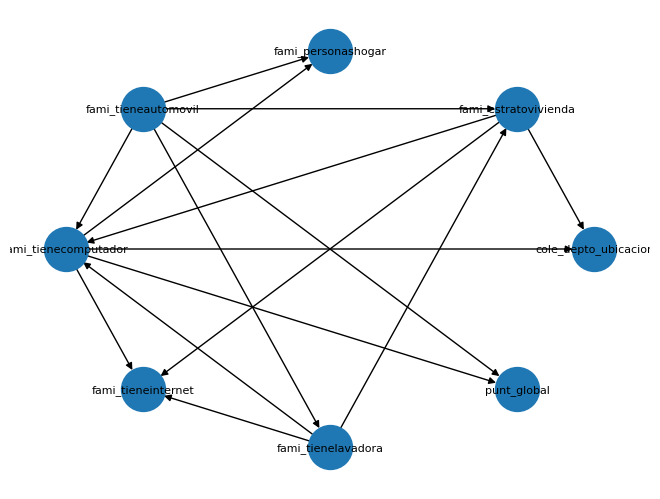

In [13]:
# Dibujamos el grafo
nx.draw_circular(modelo3,with_labels=True,arrowsize=10,font_size=8,node_size=1000)
plt.show()

In [19]:
print(modelo2)
print(modelo2.nodes())
print(modelo2.edges())

DAG with 8 nodes and 12 edges
['cole_depto_ubicacion', 'fami_estratovivienda', 'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora', 'punt_global']
[('fami_estratovivienda', 'fami_tieneautomovil'), ('fami_estratovivienda', 'cole_depto_ubicacion'), ('fami_estratovivienda', 'fami_tieneinternet'), ('fami_tieneautomovil', 'fami_personashogar'), ('fami_tienecomputador', 'fami_estratovivienda'), ('fami_tienecomputador', 'fami_tieneinternet'), ('fami_tienecomputador', 'fami_tieneautomovil'), ('fami_tienecomputador', 'punt_global'), ('fami_tienelavadora', 'fami_tienecomputador'), ('fami_tienelavadora', 'fami_estratovivienda'), ('fami_tienelavadora', 'fami_tieneinternet'), ('fami_tienelavadora', 'fami_tieneautomovil')]


In [17]:
# Evaluamos el modelo
print("Modelo por Puntaje - BicScore:" + str(scoring_method.score(modelo2)))

Modelo por Restricciones - BicScore:-211253.33033868758


## Estimación de Probabilidades

In [27]:
# Editamos la base de datos para quedarnos con las columnas que nos interesan 
data_sel = ['cole_depto_ubicacion', 'fami_estratovivienda', 'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora', 'punt_global']
data_sel = df[data_sel]
data_sel

,cole_depto_ubicacion,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,punt_global
0,VALLE,Estrato 3,9 o más,Si,Si,No,No,274
1,VALLE,Estrato 5,3 a 4,Si,Si,Si,Si,270
2,VALLE,Estrato 1,3 a 4,No,No,No,Si,222
3,VALLE,Estrato 6,5 a 6,Si,Si,Si,Si,305
4,CUNDINAMARCA,Estrato 4,3 a 4,Si,Si,Si,Si,359
...,...,...,...,...,...,...,...,...
18418,VALLE,Estrato 5,3 a 4,Si,Si,Si,Si,340
18419,VALLE,Estrato 4,3 a 4,Si,Si,Si,Si,324
18420,CAUCA,Estrato 3,5 a 6,No,No,Si,Si,227
18421,BOGOTÁ,Estrato 3,7 a 8,Si,Si,Si,Si,187


In [28]:
# Creamos el modelo como una red bayesiana
redbicscore= BayesianNetwork([('fami_estratovivienda', 'fami_tieneautomovil'), ('fami_estratovivienda', 'cole_depto_ubicacion'), ('fami_estratovivienda', 'fami_tieneinternet'), ('fami_tieneautomovil', 'fami_personashogar'), ('fami_tienecomputador', 'fami_estratovivienda'), ('fami_tienecomputador', 'fami_tieneinternet'), ('fami_tienecomputador', 'fami_tieneautomovil'), ('fami_tienecomputador', 'punt_global'), ('fami_tienelavadora', 'fami_tienecomputador'), ('fami_tienelavadora', 'fami_estratovivienda'), ('fami_tienelavadora', 'fami_tieneinternet'), ('fami_tienelavadora', 'fami_tieneautomovil')])

train, test = train_test_split(data_sel, test_size=0.2, random_state=98)
#Calcular los parametros> probabilidades condicionales mediante maxima verosimilitud

tiempo_inicial_est = datetime.now()
emv = MaximumLikelihoodEstimator(model=redrestricciones, data=train)

redbicscore.fit(data=train, estimator = MaximumLikelihoodEstimator)

#Chequiar modelo
redbicscore.check_model()
tiempo_comp_est = datetime.now() - tiempo_inicial_est
print(f'El tiempo computacional de estimación de los parametros de probabilidades condicionales fue:{tiempo_comp_est}')
infer = VariableElimination(redbicscore)

El tiempo computacional de estimación de los parametros de probabilidades condicionales fue:0:00:00.202245


In [ ]:
# Evaluamos el modelo

In [23]:
# Guardamos el modelo
# Como un .pkl
filename='restricciones.pkl'
with open(filename,'wb') as file:
    pickle.dump(redrestricciones, file)
    file.close()

## Método de Puntajes - K2Score

In [9]:
tiempo_inicial = datetime.now()
scoring_method = K2Score(data=df)
est = HillClimbSearch(data=df)
modelo3 = esth.estimate(
    scoring_method=scoring_method, max_indegree=28, max_iter=35
)

tiempo_total = datetime.now() - tiempo_inicial
print('El tiempo computacional fue de: ' + str(tiempo_total))

  0%|          | 0/35 [00:00<?, ?it/s]

El tiempo computacional fue de: 0:00:05.019572


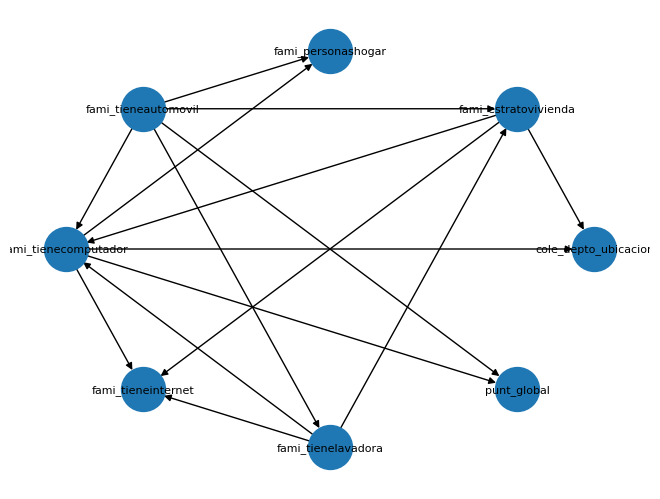

In [16]:
# Dibujamos el grafo
nx.draw_circular(modelo3,with_labels=True,arrowsize=10,font_size=8,node_size=1000)
plt.show()

In [20]:
print(modelo3)
print(modelo3.nodes())
print(modelo3.edges())

DAG with 8 nodes and 15 edges
['cole_depto_ubicacion', 'fami_estratovivienda', 'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora', 'punt_global']
[('fami_estratovivienda', 'fami_tienecomputador'), ('fami_estratovivienda', 'cole_depto_ubicacion'), ('fami_estratovivienda', 'fami_tieneinternet'), ('fami_tieneautomovil', 'fami_estratovivienda'), ('fami_tieneautomovil', 'punt_global'), ('fami_tieneautomovil', 'fami_tienecomputador'), ('fami_tieneautomovil', 'fami_tienelavadora'), ('fami_tieneautomovil', 'fami_personashogar'), ('fami_tienecomputador', 'fami_tieneinternet'), ('fami_tienecomputador', 'punt_global'), ('fami_tienecomputador', 'cole_depto_ubicacion'), ('fami_tienecomputador', 'fami_personashogar'), ('fami_tienelavadora', 'fami_tieneinternet'), ('fami_tienelavadora', 'fami_tienecomputador'), ('fami_tienelavadora', 'fami_estratovivienda')]


In [15]:
# Evaluamos el modelo
print("Modelo por Puntajes - K2Score:" + str(scoring_method.score(modelo3)))

Modelo por Restricciones - K2Score:-210305.527049691


In [29]:
## Estimación de Probabilidades
# Seleccionamos las variables que nos interesan
data_sel = ['cole_depto_ubicacion', 'fami_estratovivienda', 'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora', 'punt_global']
data_sel = df[data_sel]
data_sel

,cole_depto_ubicacion,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,punt_global
0,VALLE,Estrato 3,9 o más,Si,Si,No,No,274
1,VALLE,Estrato 5,3 a 4,Si,Si,Si,Si,270
2,VALLE,Estrato 1,3 a 4,No,No,No,Si,222
3,VALLE,Estrato 6,5 a 6,Si,Si,Si,Si,305
4,CUNDINAMARCA,Estrato 4,3 a 4,Si,Si,Si,Si,359
...,...,...,...,...,...,...,...,...
18418,VALLE,Estrato 5,3 a 4,Si,Si,Si,Si,340
18419,VALLE,Estrato 4,3 a 4,Si,Si,Si,Si,324
18420,CAUCA,Estrato 3,5 a 6,No,No,Si,Si,227
18421,BOGOTÁ,Estrato 3,7 a 8,Si,Si,Si,Si,187


In [30]:
# Creamos el modelo como una red bayesiana
redk2score= BayesianNetwork([('fami_estratovivienda', 'fami_tienecomputador'), ('fami_estratovivienda', 'cole_depto_ubicacion'), ('fami_estratovivienda', 'fami_tieneinternet'), ('fami_tieneautomovil', 'fami_estratovivienda'), ('fami_tieneautomovil', 'punt_global'), ('fami_tieneautomovil', 'fami_tienecomputador'), ('fami_tieneautomovil', 'fami_tienelavadora'), ('fami_tieneautomovil', 'fami_personashogar'), ('fami_tienecomputador', 'fami_tieneinternet'), ('fami_tienecomputador', 'punt_global'), ('fami_tienecomputador', 'cole_depto_ubicacion'), ('fami_tienecomputador', 'fami_personashogar'), ('fami_tienelavadora', 'fami_tieneinternet'), ('fami_tienelavadora', 'fami_tienecomputador'), ('fami_tienelavadora', 'fami_estratovivienda')])

train, test = train_test_split(data_sel, test_size=0.2, random_state=98)
#Calcular los parametros> probabilidades condicionales mediante maxima verosimilitud

tiempo_inicial_est = datetime.now()
emv = MaximumLikelihoodEstimator(model=redk2score, data=train)

redk2score.fit(data=train, estimator = MaximumLikelihoodEstimator)

#Chequiar modelo
redbicscore.check_model()
tiempo_comp_est = datetime.now() - tiempo_inicial_est
print(f'El tiempo computacional de estimación de los parametros de probabilidades condicionales fue:{tiempo_comp_est}')
infer = VariableElimination(redk2score)

El tiempo computacional de estimación de los parametros de probabilidades condicionales fue:0:00:00.249857


## Hacemos métricas de los modelos

## Hacemos inferencia